In [71]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg
import json
import SimpleITK as sitk

#### calculate the metrics for a dataset and test patient ID

In [25]:
DATASET_ID = 160
TEST_ID = 1

In [52]:
RAW_DIR = '/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw'
DATASET_BASE_DIR = '{}/Dataset{}_RNSH_HFlung'.format(RAW_DIR, DATASET_ID)

In [50]:
prediction_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()
prediction_img.shape

(320, 320, 300)

In [51]:
label_img = nib.load('{}/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_BASE_DIR, TEST_ID)).get_fdata()
label_img.shape

(320, 320, 300)

In [28]:
DISPLAY_IDX = 100

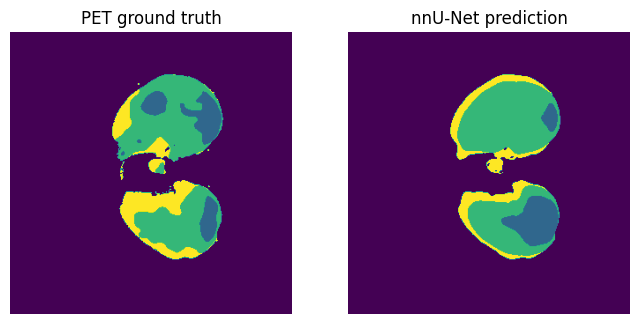

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(label_img[:,:,DISPLAY_IDX])
ax1.set_title('PET ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX])
ax2.set_title('nnU-Net prediction')
ax2.set_axis_off()

In [30]:
seg = prediction_img.ravel()
gt = label_img.ravel()

In [31]:
foreground_idxs = gt > 0

sp = spearmanr(seg[foreground_idxs], gt[foreground_idxs])
print('Spearman')
print(np.round(sp[0],2))

Spearman
0.38


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
cm = confusion_matrix(label_img.ravel(), prediction_img.ravel())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

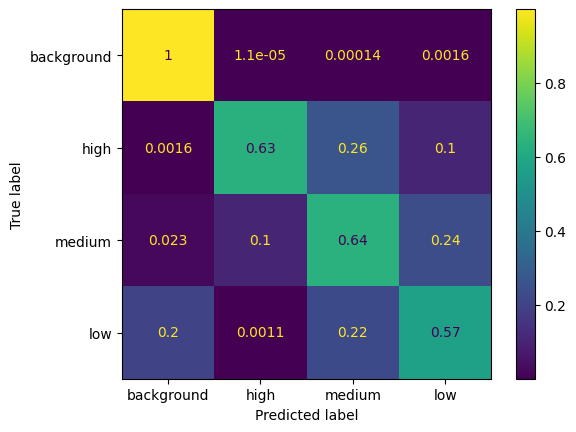

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()

In [35]:
dsc = {}
print('DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

DSC
high: 0.72
medium: 0.64
low: 0.56


In [36]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

In [37]:
vs = metrics[0]['vs']
print('volume similarity')
print('high: {}'.format(round(vs[1],2)))
print('medium: {}'.format(round(vs[2],2)))
print('low: {}'.format(round(vs[3],2)))

volume similarity
high: 0.26
medium: -0.0
low: -0.03


In [38]:
hd = metrics[0]['hd']
print('Hausdorff distance')
print('high: {}'.format(round(hd[1])))
print('medium: {}'.format(round(hd[2])))
print('low: {}'.format(round(hd[3])))

Hausdorff distance
high: 84
medium: 30
low: 65


In [39]:
hd95 = metrics[0]['hd95']
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(hd95[1])))
print('medium: {}'.format(round(hd95[2])))
print('low: {}'.format(round(hd95[3])))

Hausdorff distance 95% percentile
high: 27
medium: 16
low: 15


#### store the metrics by dataset and test patient ID

In [40]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/nnunet-metrics.pkl'.format(ANALYSIS_DIR)

In [41]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

patient_d = {'dataset_id':DATASET_ID, 'test_id':TEST_ID, 
             'confusion_matrix':cm, 'spearman_correlation':np.round(sp[0],2), 
             'DSC_low':np.round(dsc['low'],2), 'DSC_medium':np.round(dsc['medium'],2), 'DSC_high':np.round(dsc['high'],2),
             'VS_low':np.round(vs[3],2), 'VS_medium':np.round(vs[2],2), 'VS_high':np.round(vs[1],2),
             'HD_low':np.round(hd[3]), 'HD_medium':np.round(hd[2]), 'HD_high':np.round(hd[1]),
             'HD95_low':np.round(hd95[3]), 'HD95_medium':np.round(hd95[2]), 'HD95_high':np.round(hd95[1]),
            }

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

patient_id = '{:03d}-{:02d}'.format(DATASET_ID, TEST_ID)
analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
        pickle.dump(analysis_d, f)

#### calculate the mean performance over all training sets

In [42]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/nnunet-metrics.pkl'.format(ANALYSIS_DIR)

In [43]:
if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
        print('loaded {} metrics: {}'.format(len(analysis_d), list(analysis_d.keys())))
else:
    print('could not load the analysis file from {}'.format(ANALYSIS_FILE))

loaded 2 metrics: ['160-00', '160-01']


In [44]:
print('Spearman correlation')
print('mean {}, std {}'.format(round(np.mean([value['spearman_correlation'] for key, value in analysis_d.items()]) ,2), round(np.std([value['spearman_correlation'] for key, value in analysis_d.items()]), 2)))
print()
print('DSC')
print('high {}, std {}'.format(round(np.mean([value['DSC_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['DSC_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['DSC_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_low'] for key, value in analysis_d.items()]), 2)))
print()
print('volume similarity')
print('high {}, std {}'.format(round(np.mean([value['VS_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['VS_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['VS_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_low'] for key, value in analysis_d.items()]), 2)))
print()
print('Hausdorff distance')
print('high {}, std {}'.format(round(np.mean([value['HD_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['HD_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['HD_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_low'] for key, value in analysis_d.items()]), 2)))
print()
print('Hausdorff distance 95% percentile')
print('high {}, std {}'.format(round(np.mean([value['HD95_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['HD95_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['HD95_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_low'] for key, value in analysis_d.items()]), 2)))


Spearman correlation
mean 0.42, std 0.04

DSC
high 0.72, std 0.01
medium 0.63, std 0.01
low 0.57, std 0.01

volume similarity
high 0.23, std 0.03
medium 0.0, std 0.0
low -0.05, std 0.02

Hausdorff distance
high 81.5, std 2.5
medium 32.0, std 2.0
low 62.0, std 3.0

Hausdorff distance 95% percentile
high 35.0, std 8.0
medium 16.0, std 0.0
low 13.0, std 2.0


In [45]:
cm_mean = np.mean([value['confusion_matrix'] for key, value in analysis_d.items()], axis=0)

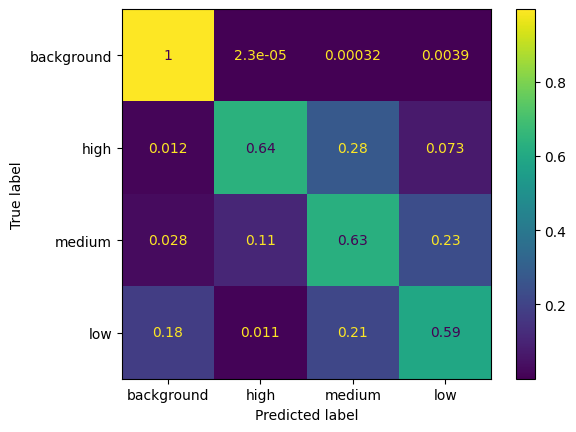

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()

#### compare with DIR approach

In [61]:
# get the patient ID for this hold-out test patient
MAPPING_FILE = '{}/patient-mapping-Dataset{}_RNSH_HFlung.json'.format(RAW_DIR, DATASET_ID)

with open(MAPPING_FILE, 'r') as fp:
    patient_map_d = json.load(fp)

In [84]:
patient_id = int(patient_map_d['test'][TEST_ID][0].split('/')[-1].split('.')[0].split('Patient')[1])
patient_id

4

In [85]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
EVALUATION_DIR = '{}/evaluation'.format(PREPROCESSED_BASE_DIR)
PATIENT_EVALUATION_DIR = '{}/Patient{:02d}'.format(EVALUATION_DIR, patient_id)

In [91]:
pet_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/pet-label.mha'.format(PATIENT_EVALUATION_DIR)))
ctvi_jac_label_arr = sitk.GetArrayFromImage(sitk.ReadImage('{}/ctvi-jac-label.mha'.format(PATIENT_EVALUATION_DIR)))
pet_label_arr.shape, ctvi_jac_label_arr.shape

((319, 500, 500), (319, 500, 500))

In [87]:
seg = ctvi_jac_label_arr.ravel()
gt = pet_label_arr.ravel()

In [88]:
foreground_idxs = gt > 0

sp = spearmanr(seg[foreground_idxs], gt[foreground_idxs])
print('Spearman')
print(np.round(sp[0],2))

Spearman
0.6


In [89]:
dsc = {}
print('DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

DSC
high: 0.67
medium: 0.52
low: 0.46
